# General Equilibrium

So far, we have solved the household’s problem by treating prices — such as interest and wage rates — as given. In general equilibrium, these prices are determined endogenously. Similarly, government-related variables, such as social security benefits and tax rates, are also endogenously determined. 

We first formulate the model and then define the equilibrium concept. Finally, we describe the numerical method used to solve the model.

## Setup

There are three sectors in the model: households, a (representative) firm, and the government. For notational convenience, we focus on a **stationary economy** and define a **stationary equilibrium**.

### Household

Households in this economy are similar to those discussed in the previous section, except that we now allow for **endogenous labor supply**, **public pensions**, and **labor income taxation**.

The economy is populated by overlapping generations. A cohort of households enters the economy at age 20 ($j = 1$) in each period. These households are born without assets and live up to age 80 ($j = J = 61$). Each period, households derive utility from consumption and leisure, and discount future utility by the factor $\beta$.

Each period, households choose how much to consume and save. Until age 65 ($j = J_R = 46$), they also decide how many hours to work in the labor market, denoted by $h$. They earn gross labor income of $wh$, where $w$ is the market wage. The time endowment is normalized to 1 and is allocated between work $(h)$ and leisure $(1 - h)$. Labor income is taxed at rate $\tau_w$. 

After age $J_R$, households retire and receive a public pension benefit $p = \theta w$, where $\theta \in [0,1]$ is the income replacement rate. Assets earn an interest rate $r$. Let $\mu(j)$ denote the measure of households of age $j$, normalized such that $\sum_{j=1}^{J} \mu(j) = 1$. Assuming no population growth, the mass of each generation is constant: $\mu(j) = \mu(j')$ for any $j, j'$.

Households are not allowed to borrow. Their problem is given by:

\begin{align*}
    & \max_{\{c_j, h_j\}_{j=1}^J} \sum_{j=1}^J \beta^{j-1} u(c_j, 1 - h_j) \\
    \text{s.t.} \quad
    c_j &= 
    \begin{cases}
        (1 - \tau_w) w h_j + (1 + r) a_j - a_{j+1} & \text{if } j \le J_R \\
        (1 + r) a_j - a_{j+1} + p & \text{if } j \in \{J_R+1, \dots, J-1\} \\
        (1 + r) a_j + p & \text{if } j = J
    \end{cases} \\
    & a_1 = 0, \quad a_{j+1} \ge 0 \quad \forall j
\end{align*}

### Firm

There is a representative firm that produces final goods $Y$ using the production function:

$$
F(K, H) = K^\alpha H^{1 - \alpha},
$$

where $K$ and $H$ represent capital and labor inputs, respectively. The parameter $\alpha$ governs capital's share in output. Capital depreciates at rate $\delta$, and the firm bears this depreciation cost.

### Government

The government provides public pensions to retirees, calculated as a fraction $\theta$ of the current wage. It finances these benefits by taxing labor income at rate $\tau_w$.

## Stationary Equilibrium

We focus on a **stationary equilibrium**, in which aggregate variables — such as prices and the tax rate — are constant over time. The definition is as follows:

### **Definition (Stationary Equilibrium)**

Given $\theta$, a **stationary equilibrium** consists of household decision rules for consumption, savings, and labor supply $(c(j), a'(j), h(j))$, aggregate quantities $(K, H)$, prices $(r, w)$, and a tax rate $(\tau_w)$, such that:

1. **Household optimization**:  
   Households maximize their lifetime utility by solving the dynamic problem described above.

2. **Firm profit maximization**:  
   The firm’s first-order conditions are satisfied:
   $$
   r = \left( \frac{K}{H} \right)^{\alpha - 1} - \delta
   $$
   $$
   w = \left( \frac{K}{H} \right)^{\alpha}
   $$

3. **Factor market clearing**:
   $$
   K = \sum_{j=1}^{J} a(j) \mu(j)
   $$
   $$
   H = \sum_{j=1}^{J_R} h(j) \mu(j)
   $$

4. **Government budget constraint**:
   The labor tax rate balances the government budget:
   $$
   \tau_w w H = w \theta \underbrace{\sum_{j=J_R+1}^{J} \mu(j)}_{\equiv O}
   $$
   which implies:
   $$
   \tau_w = \theta \cdot \frac{O}{H}
   $$

---

## Algorithm

To solve the general equilibrium numerically, we work with two loops: an outer loop for checking if markets are clear with given prices, and an inner loop for solving household's problem and deriving factor supply.

1. Make initial guesses for the tax rate $\tau_w$ and for aggregate quantities $(K,H)$, which pin down prices $(r,w)$ from the firm's optimality conditions. 
2. (Inner loop) Solve the household problem and obtain household's decision rules given these prices and tax rate.
3. Based on the household decision rules, compute the implied quantities, prices, and tax rate. 
4. If these implied aggregate variables are not close enough to their guesses, update their guesses and return to the step 2.

In [11]:
# set household optimization routine.
function solve_lifecycle(r,w,τ)

    # parameters
    β=0.98
    σ=2.0 # additional parameter (curvature)
    ω=0.5 # additional parameter (weight)
    θ=0.3 # income replacement for pension benefits

    # discretization for asset space
    mina = 1.e-5 # lower bound (close to zero but not exactly (to avoid c=0))
    maxa = 10.0  # upper bound
    na   = 1000  # number of grid
    grida = collect(LinRange(mina,maxa,na)); # construct discretized asset space

    # age related parameters
    J=61  # length of lifecycle
    JR=46 # timing of retirement

    # value function and policy functions
    V = zeros(na,J); # value function V(a,j)
    Va = zeros(na);  # vector for grid search
    apol = zeros(na,J); # policy function for saving (value) a(a,J)
    apol_arg = zeros(Int,na,J); # policy function for saving (index over asset space, grida)
    cpol = zeros(na,J)  # policy function for consumption c(a,J)
    hpol = zeros(na,J) # policy function for labor 

    penalty=-1.e+8

    for jc in J:-1:1 # solve backward
        acc_start=1 # for speed up
        for ac in 1:na
            if (jc==J) # compute final consumption given a
                c = (1.0+r)*grida[ac]+w*θ
                if (c>0)
                    V[ac,jc]=((c^ω)^(1.0-σ))/(1.0-σ)
                else # "punish" c<=0
                    V[ac,jc]=penalty
                end
                cpol[ac,jc]=c; # store it in policy function for c
            elseif (JR < jc) && (jc < J) # retirement period (except for the final period)
                Va.=penalty;
                v0=penalty
                for acc in acc_start:na
                    c = (1.0+r)*grida[ac]-grida[acc]+w*θ
                    if (c>0)
                        Va[acc] = ((c^ω)^(1.0-σ))/(1.0-σ) + β*V[acc,jc+1]
                    else
                        Va[acc] = penalty
                    end

                    if (Va[acc]>v0)
                        v0=Va[acc]
                        acc_start=acc
                    else
                        break
                    end
                end
                arg = acc_start
                apol_arg[ac,jc]=arg
                apol[ac,jc] = grida[arg]
                V[ac,jc] = Va[arg]
                cpol[ac,jc]=(1.0+r)*grida[ac]-grida[arg];
            else
                Va.=penalty;
                v0=penalty
                for acc in acc_start:na
                    l = (1.0-ω) * ((1.0+r)*grida[ac]-grida[acc] + w)/w
                    c = (1.0-τ)*w*(1.0-l)+(1.0+r)*grida[ac]-grida[acc]
                    if (c>0 && l>0)
                        Va[acc] = ((c^ω * l^(1.0-ω))^(1.0-σ))/(1.0-σ) + β*V[acc,jc+1]
                    else
                        Va[acc] = penalty
                    end

                    if (Va[acc]>v0)
                        v0=Va[acc]
                        acc_start=acc
                    else
                        break
                    end

                end
                arg = acc_start
                acc_start = arg
                apol_arg[ac,jc]=arg
                apol[ac,jc] = grida[arg]
                V[ac,jc] = Va[arg]
                l = (1.0-ω) * ((1.0+r)*grida[ac]-grida[arg] + w)/w
                cpol[ac,jc]=(1.0-τ)*w*(1.0-l) + (1.0+r)*grida[ac]-grida[arg];
                hpol[ac,jc] = 1.0-l
            end
        end
    end

    # find asset profile aj
    aj = zeros(J);
    aj[1]=grida[1]; # start from no-asset
    a_arg = ones(Int,J);
    arg_yesterday=1;
    for jc in 2:J
        arg_yesterday=a_arg[jc-1];
        arg = apol_arg[arg_yesterday,jc-1];
        aj[jc]=grida[arg];
        a_arg[jc]=arg;
    end

    # find consumption
    cj = zeros(J);
    hj = zeros(J)
    for jc in 1:J
        arg = a_arg[jc];
        cj[jc]=cpol[arg,jc]
        hj[jc]=hpol[arg,jc]
    end

    muj = fill(1.0/J,J);

    return aj,hj,muj,J,JR,θ
    
end

solve_lifecycle (generic function with 1 method)

In [17]:
# SOLVE GE
using Printf
# parameters
α=0.33;
δ=0.1;

# step 1. Make initial guesses
K = 6.0;
H = 0.5;
τ = 0.1
imp_K = K;
imp_H = H;
imp_τ = τ;

dif=[1.0, 1.0, 1.0]; # for (K,H,τ)
tol=[1.e-3, 1.e-3, 1.e-3]; # for (K,H,τ)

iter=1;
max_iter=1000; # for when something is wrong.

# to visualize how it converges
Excess_K = zeros(max_iter)
Excess_H = zeros(max_iter)
r_iter   = zeros(max_iter)
w_iter   = zeros(max_iter)

while any(dif .> tol)

    # (step 4: update)
    adj=0.1;
    K = imp_K*adj + K*(1.0-adj)
    H = imp_H*adj + H*(1.0-adj)
    τ = imp_τ*adj + τ*(1.0-adj)

    # step 2. Household problems
    r = (K/H)^(α-1.0) - δ
    w = (K/H)^α
    aj,hj,muj,J,JR,θ = solve_lifecycle(r,w,τ)

    # step 3. Compute the implied aggregate variables
    imp_K = sum(aj.*muj)
    imp_H = sum(hj.*muj)
    imp_τ = θ*sum(muj[JR+1:J])/imp_H

    Excess_K[iter]=K-imp_K
    Excess_H[iter]=H-imp_H
    r_iter[iter]=r
    w_iter[iter]=w

    # step 4. Check if the guesses are right. If not, update.
    dif_K = abs(K-imp_K)/K
    dif_H = abs(H-imp_H)/H
    dif_τ = abs(τ-imp_τ)/τ

    dif .= [dif_K,dif_H,dif_τ];

    # println("Iter:", iter, "max(dif):",maximum(dif))

    if (iter>max_iter)
        break
    end
    
    iter+=1;

end
@show iter
@printf("dif_K = %.5f\ndif_H = %.5f\ndif_t = %.5f\n", dif...)
r = (K/H)^(α-1.0) - δ
w = (K/H)^α

@printf("K = %.5f\nH = %.5f\nr = %.5f\nw = %.5f\nτ = %.5f\n", K, H, r, w, τ)

iter = 61
dif_K = 0.00057
dif_H = 0.00079
dif_t = 0.00098
K = 6.20465
H = 0.35453
r = 0.04694
w = 2.57166
τ = 0.20804


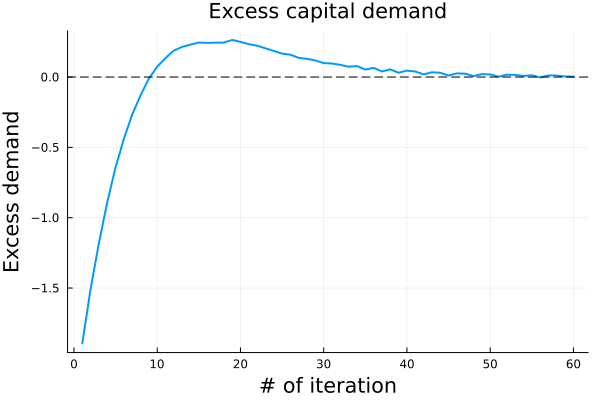

In [31]:
# plot excess capital demand
using Plots
plot(1:iter-1, Excess_K[1:iter-1],
    xlabel="# of iteration",
    ylabel="Excess demand",
    title="Excess capital demand",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)
hline!([0], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=0

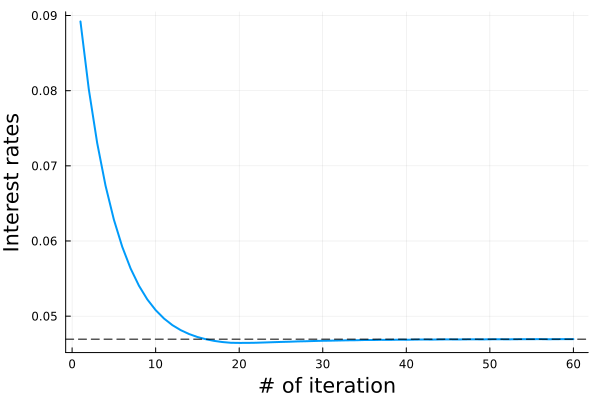

In [32]:
# plot interest rate convergence
plot(1:iter-1, r_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel="Interest rates",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))
hline!([r], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=r

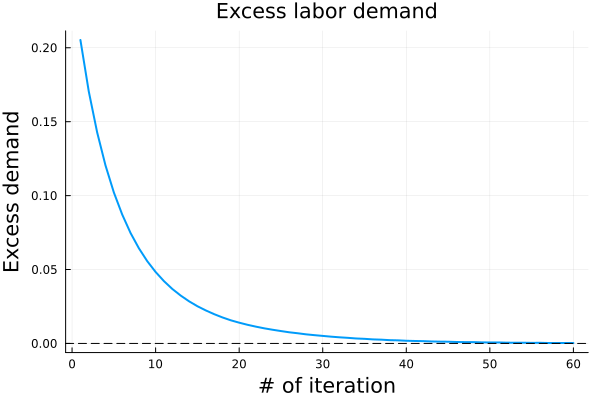

In [33]:
# plot excess labor demand
using Plots
plot(1:iter-1, Excess_H[1:iter-1],
    xlabel="# of iteration",
    ylabel="Excess demand",
    title="Excess labor demand",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))
hline!([0], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=0

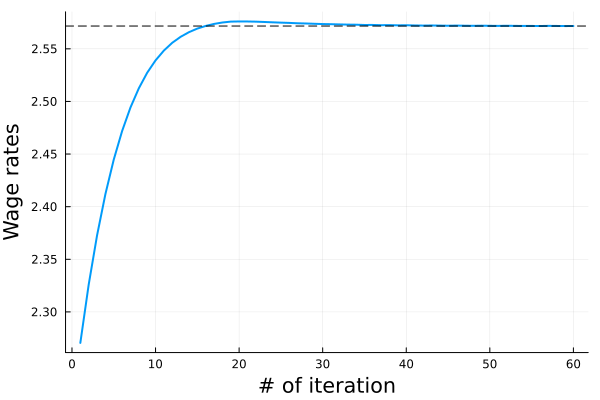

In [34]:
# plot wage rate convergence
plot(1:iter-1, w_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel="Wage rates",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))
hline!([w], lw=1, lc=:black, ls=:dash, label="")  # horizontal line at y=r